In [75]:
# In the Python Console write this command: pip install numpy pandas matplotlib tensorflow scikit-learn keras-tuner

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import keras_tuner as kt

In [76]:
# ======================
# 1. Data Preparation
# ======================
def load_and_preprocess(data_path):
    """Load and preprocess soil moisture data"""
    data = pd.read_csv(data_path)
    data['Time'] = pd.to_datetime(data['Time'], format='%m/%d/%Y')
    data.set_index('Time', inplace=True)

    # Select features and target
    features = ['Precipitation (mm)', 'Evapotranspiration (mm)',
               'Runoff (mm)', 'Change in Storage (mm)']
    target = 'Soil Moisture (mm)'

    X = data[features]
    y = data[target]

    # Normalize data
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()

    X_scaled = scaler_X.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

    return X_scaled, y_scaled, scaler_X, scaler_y, data

In [77]:
# ======================
# 2. Sequence Creation
# ======================
def create_sequences(X, y, time_steps=6):
    """Create time-series sequences for LSTM"""
    X_seq, y_seq = [], []
    for i in range(len(X) - time_steps):
        X_seq.append(X[i:i+time_steps])
        y_seq.append(y[i+time_steps])
    return np.array(X_seq), np.array(y_seq)

In [81]:
# # ======================
# # 3. Model Building
# # ======================
# def build_model(time_steps, n_features):
#     """Build LSTM model for 2000mm depth prediction"""
#     model = Sequential([
#         LSTM(128, activation='relu', return_sequences=True,
#              input_shape=(time_steps, n_features)),
#         Dropout(0.3),
#         LSTM(64, activation='relu'),
#         Dropout(0.2),
#         Dense(32, activation='relu'),
#         Dense(1)
#     ])
#
#     model.compile(optimizer=Adam(learning_rate=0.001),
#                  loss='mse',
#                  metrics=['mae'])
#     return model

# ======================
# 3. Model Building with Hyperparameter Tuning
# ======================
def build_model(hp):
    """Build LSTM model with hyperparameter tuning"""
    model = Sequential()

    # Tune the number of LSTM layers (1-3)
    for i in range(hp.Int('num_layers', 1, 3)):
        if i == 0:
            # First layer
            model.add(LSTM(
                units=hp.Int(f'units_layer_{i}', min_value=32, max_value=256, step=32),
                activation=hp.Choice(f'activation_{i}', ['relu', 'tanh']),
                return_sequences=i < 2,  # Only return sequences if more layers follow
                input_shape=(time_steps, n_features)
            ))
        else:
            # Subsequent layers
            model.add(LSTM(
                units=hp.Int(f'units_layer_{i}', min_value=32, max_value=256, step=32),
                activation=hp.Choice(f'activation_{i}', ['relu', 'tanh']),
                return_sequences=i < 2
            ))

        # Add dropout with tunable rate
        model.add(Dropout(hp.Float(f'dropout_{i}', min_value=0.1, max_value=0.5, step=0.1)))

    # Tune the number of dense layers (0-2)
    for j in range(hp.Int('num_dense_layers', 0, 2)):
        model.add(Dense(
            units=hp.Int(f'dense_units_{j}', min_value=16, max_value=128, step=16),
            activation=hp.Choice(f'dense_activation_{j}', ['relu', 'tanh'])
        ))

    model.add(Dense(1))

    # Tune the learning rate
    learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='mse',
        metrics=['mae']
    )

    return model

def hyperparameter_tuning(X_train, y_train, X_val, y_val):
    """Perform hyperparameter tuning using Keras Tuner"""
    tuner = kt.Hyperband(
        build_model,
        objective='val_loss',
        max_epochs=50,
        factor=3,
        directory='tuner_results',
        project_name='soil_moisture_prediction',
        overwrite=True
    )

    early_stop = EarlyStopping(monitor='val_loss', patience=5)

    tuner.search(
        X_train, y_train,
        epochs=100,
        validation_data=(X_val, y_val),
        callbacks=[early_stop],
        batch_size=32,
        verbose=1
    )

    # Get the optimal hyperparameters
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

    print(f"""
    Best hyperparameters:
    - Number of LSTM layers: {best_hps.get('num_layers')}
    - Units in LSTM layers: {[best_hps.get(f'units_layer_{i}') for i in range(best_hps.get('num_layers'))]}
    - Activation functions: {[best_hps.get(f'activation_{i}') for i in range(best_hps.get('num_layers'))]}
    - Dropout rates: {[best_hps.get(f'dropout_{i}') for i in range(best_hps.get('num_layers'))]}
    - Number of dense layers: {best_hps.get('num_dense_layers')}
    - Learning rate: {best_hps.get('learning_rate')}
    """)

    # Build the model with the best hyperparameters
    model = tuner.hypermodel.build(best_hps)

    return model

In [84]:
# ======================
# 4. Rolling Forecast Validation
# ======================
def rolling_forecast(model, X, y, initial_train_size):
    """Rolling forecast validation for temporal data"""
    predictions = []

    for i in range(len(y) - initial_train_size):
        # Retrain model on expanding window
        model.fit(X[:initial_train_size+i],
                 y[:initial_train_size+i],
                 epochs=50,
                 batch_size=16,
                 verbose=0,
                 callbacks=[EarlyStopping(patience=3)])

        # Predict next step
        y_pred = model.predict(X[initial_train_size+i:initial_train_size+i+1])
        predictions.append(y_pred[0,0])

    return np.array(predictions)

Trial 90 Complete [00h 00m 19s]
val_loss: 0.10657134652137756

Best val_loss So Far: 0.012506960891187191
Total elapsed time: 00h 13m 32s

    Best hyperparameters:
    - Number of LSTM layers: 3
    - Units in LSTM layers: [192, 64, 128]
    - Activation functions: ['tanh', 'tanh', 'tanh']
    - Dropout rates: [0.5, 0.1, 0.2]
    - Number of dense layers: 2
    - Learning rate: 0.001
    

Training final model with best hyperparameters...
Epoch 1/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 231ms/step - loss: 0.5158 - mae: 0.6767 - val_loss: 0.3628 - val_mae: 0.5770
Epoch 2/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.4240 - mae: 0.6075 - val_loss: 0.2312 - val_mae: 0.4521
Epoch 3/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.2437 - mae: 0.4458 - val_loss: 0.0459 - val_mae: 0.1893
Epoch 4/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0569 - mae: 0.1951 - val_loss: 0.1042 - val_mae: 0.2814
Epoch 5/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.1403 - mae: 0.3118 - val_loss: 

C:\Users\markl\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\callbacks\early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae
  current = self.get_monitor_value(logs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Rolling Forecast RMSE: 86.70 mm


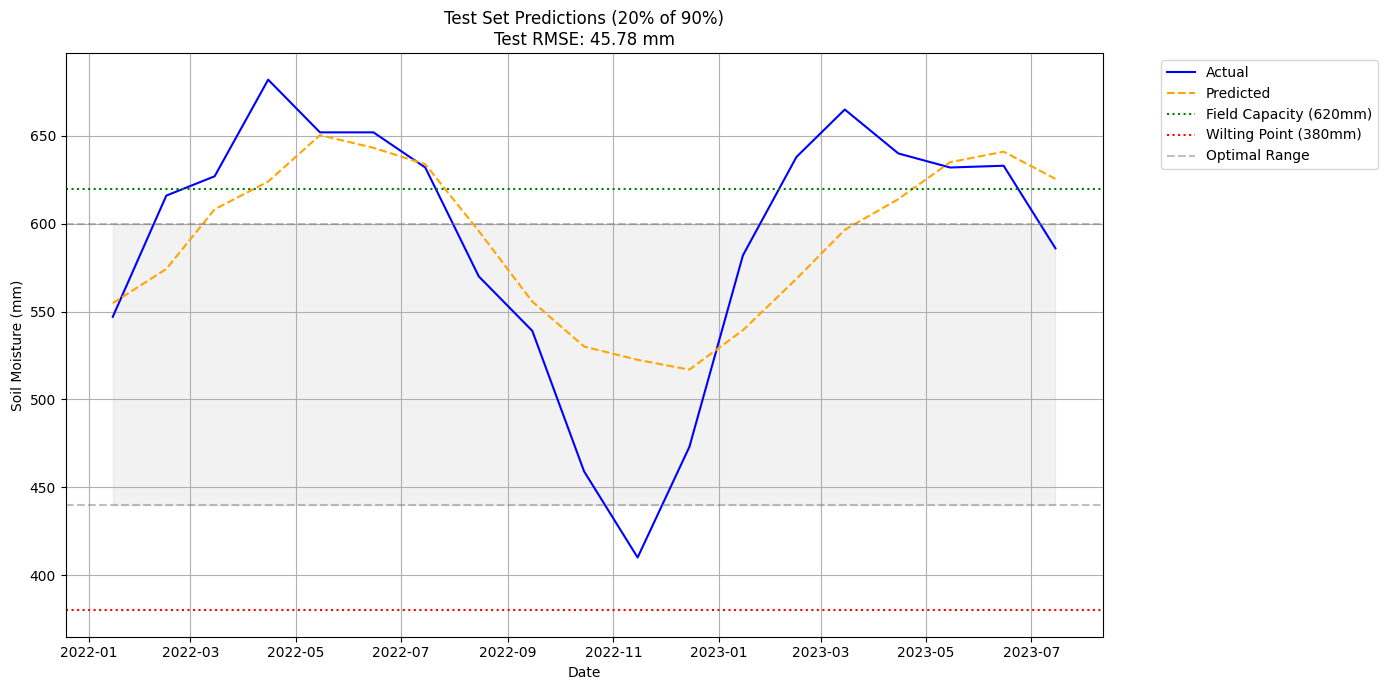

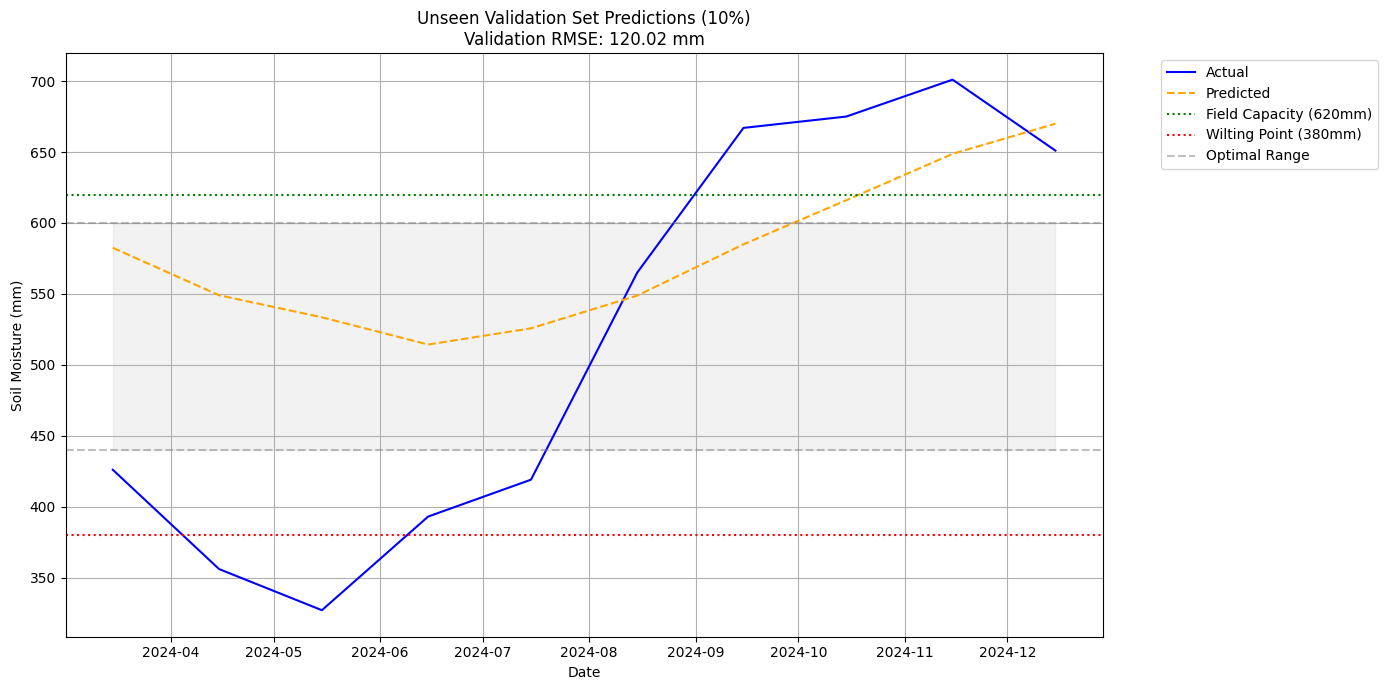

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


C:\Users\markl\AppData\Local\Temp\ipykernel_29148\4218781503.py:183: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=data.index[-1], periods=12, freq='M')


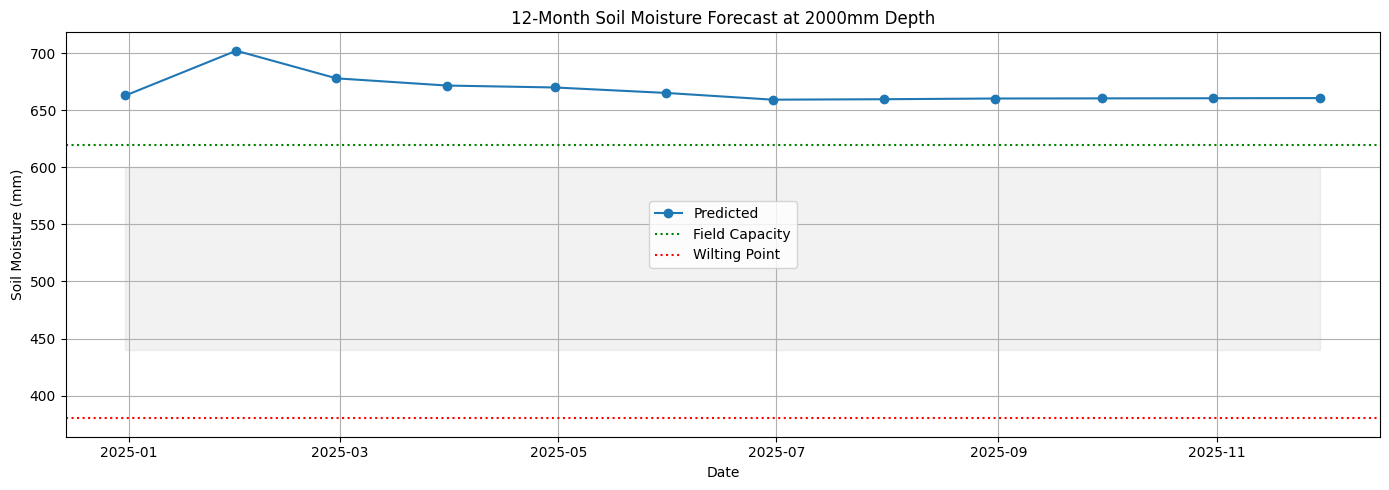


Future Predictions (next 12 months):
            Predicted Soil Moisture (mm)
2024-12-31                    663.068604
2025-01-31                    702.334961
2025-02-28                    678.109131
2025-03-31                    671.783142
2025-04-30                    670.106140
2025-05-31                    665.341797
2025-06-30                    659.407532
2025-07-31                    659.801147
2025-08-31                    660.428772
2025-09-30                    660.542847
2025-10-31                    660.660217
2025-11-30                    660.806335


In [85]:
if __name__ == "__main__":
    # Load and preprocess data
    X_scaled, y_scaled, scaler_X, scaler_y, data = load_and_preprocess('Calanasan.csv')

    # Parameters
    time_steps = 6  # Using 6 months lookback period
    features = ['Precipitation (mm)', 'Evapotranspiration (mm)',
               'Runoff (mm)', 'Change in Storage (mm)']
    n_features = len(features)

    # Create sequences
    X_seq, y_seq = create_sequences(X_scaled, y_scaled, time_steps)

    # ===========================================
    # Data Partitioning: 10% Unseen + 80-20 Split
    # ===========================================
    # First reserve 10% as completely unseen validation data
    val_size = int(len(X_seq) * 0.1)
    X_remaining, X_unseen = X_seq[:-val_size], X_seq[-val_size:]
    y_remaining, y_unseen = y_seq[:-val_size], y_seq[-val_size:]

    # Then split remaining data 80-20 for training and testing
    train_size = int(len(X_remaining) * 0.8)
    X_train, X_test = X_remaining[:train_size], X_remaining[train_size:]
    y_train, y_test = y_remaining[:train_size], y_remaining[train_size:]

    print(f"\nData Partitioning Summary:")
    print(f"- Total samples: {len(X_seq)}")
    print(f"- Unseen validation set: {len(X_unseen)} samples (10%)")
    print(f"- Training set: {len(X_train)} samples (80% of remaining 90%)")
    print(f"- Test set: {len(X_test)} samples (20% of remaining 90%)")

    # ===========================================
    # Hyperparameter Tuning (on training set)
    # ===========================================
    print("\nStarting hyperparameter tuning...")
    model = hyperparameter_tuning(X_train, y_train, X_test, y_test)

    # ===========================================
    # Final Model Training
    # ===========================================
    early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

    print("\nTraining final model with best hyperparameters...")
    history = model.fit(
        X_train, y_train,
        epochs=200,
        batch_size=32,
        validation_data=(X_test, y_test),
        callbacks=[early_stop],
        verbose=1
    )

    # ===========================================
    # Evaluation on Test Set (20% of remaining 90%)
    # ===========================================
    test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
    print(f"\nTest Loss (MSE): {test_loss:.4f}")
    print(f"Test MAE: {test_mae:.4f}")

    # Predictions on test set
    y_pred = model.predict(X_test)
    y_pred_actual = scaler_y.inverse_transform(y_pred)
    y_test_actual = scaler_y.inverse_transform(y_test)

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual))
    print(f"Test RMSE: {rmse:.2f} mm")

    # Calculate R2
    r2 = r2_score(y_test_actual, y_pred_actual)
    print(f"\nAdditional Evaluation Metrics:")
    print(f"R²: {r2:.4f}")

    # Calculate AIC and BIC
    def count_parameters(model):
        return sum([np.prod(w.shape) for w in model.trainable_weights])

    n = len(y_test_actual)  # number of observations
    k = count_parameters(model)  # number of parameters
    mse = mean_squared_error(y_test_actual, y_pred_actual)

    aic = n * np.log(mse) + 2 * k
    bic = n * np.log(mse) + k * np.log(n)

    print(f"AIC: {aic:.2f}")
    print(f"BIC: {bic:.2f}")
    print(f"Number of model parameters: {k}")

    # ===========================================
    # Evaluation on Unseen Validation Set (10%)
    # ===========================================
    unseen_loss, unseen_mae = model.evaluate(X_unseen, y_unseen, verbose=0)
    print(f"\nUnseen Validation Loss (MSE): {unseen_loss:.4f}")
    print(f"Unseen Validation MAE: {unseen_mae:.4f}")

    # Predictions on unseen validation set
    y_unseen_pred = model.predict(X_unseen)
    y_unseen_pred_actual = scaler_y.inverse_transform(y_unseen_pred)
    y_unseen_actual = scaler_y.inverse_transform(y_unseen)

    # Calculate RMSE
    unseen_rmse = np.sqrt(mean_squared_error(y_unseen_actual, y_unseen_pred_actual))
    print(f"Unseen Validation RMSE: {unseen_rmse:.2f} mm")

    # ===========================================
    # Rolling Forecast Validation
    # ===========================================
    initial_train_size = int(len(X_train) * 0.8)  # 80% of training data
    predictions = rolling_forecast(model, X_train, y_train, initial_train_size)

    # Inverse scaling
    predictions_actual = scaler_y.inverse_transform(predictions.reshape(-1, 1))
    y_rolling_actual = scaler_y.inverse_transform(y_train[initial_train_size:])

    # Calculate RMSE
    rolling_rmse = np.sqrt(mean_squared_error(y_rolling_actual, predictions_actual))
    print(f"Rolling Forecast RMSE: {rolling_rmse:.2f} mm")

    # ===========================================
    # Soil Moisture Thresholds for 2000mm Depth
    # ===========================================
    # Clay loam thresholds (from your study)
    FC_mm = 620  # Field Capacity (31% of 2000mm)
    PWP_mm = 380  # Permanent Wilting Point (19% of 2000mm)
    optimal_min = 440  # 22% of 2000mm
    optimal_max = 600  # 30% of 2000mm

    # ===========================================
    # Visualization
    # ===========================================
    # Plot test set predictions
    test_dates = data.index[train_size:train_size+len(y_test_actual)]
    plt.figure(figsize=(14, 7))
    plt.plot(test_dates, y_test_actual, label='Actual', color='blue')
    plt.plot(test_dates, y_pred_actual, label='Predicted', linestyle='--', color='orange')
    plt.axhline(y=FC_mm, color='green', linestyle=':', label='Field Capacity (620mm)')
    plt.axhline(y=PWP_mm, color='red', linestyle=':', label='Wilting Point (380mm)')
    plt.axhline(y=optimal_min, color='gray', linestyle='--', alpha=0.5, label='Optimal Range')
    plt.axhline(y=optimal_max, color='gray', linestyle='--', alpha=0.5)
    plt.fill_between(test_dates, optimal_min, optimal_max, color='gray', alpha=0.1)
    plt.title(f'Test Set Predictions (20% of 90%)\nTest RMSE: {rmse:.2f} mm')
    plt.xlabel('Date')
    plt.ylabel('Soil Moisture (mm)')
    plt.legend(bbox_to_anchor=(1.05, 1))
    plt.grid()
    plt.tight_layout()
    plt.show()

    # Plot unseen validation set predictions
    unseen_dates = data.index[-len(y_unseen_actual):]
    plt.figure(figsize=(14, 7))
    plt.plot(unseen_dates, y_unseen_actual, label='Actual', color='blue')
    plt.plot(unseen_dates, y_unseen_pred_actual, label='Predicted', linestyle='--', color='orange')
    plt.axhline(y=FC_mm, color='green', linestyle=':', label='Field Capacity (620mm)')
    plt.axhline(y=PWP_mm, color='red', linestyle=':', label='Wilting Point (380mm)')
    plt.axhline(y=optimal_min, color='gray', linestyle='--', alpha=0.5, label='Optimal Range')
    plt.axhline(y=optimal_max, color='gray', linestyle='--', alpha=0.5)
    plt.fill_between(unseen_dates, optimal_min, optimal_max, color='gray', alpha=0.1)
    plt.title(f'Unseen Validation Set Predictions (10%)\nValidation RMSE: {unseen_rmse:.2f} mm')
    plt.xlabel('Date')
    plt.ylabel('Soil Moisture (mm)')
    plt.legend(bbox_to_anchor=(1.05, 1))
    plt.grid()
    plt.tight_layout()
    plt.show()

    # ===========================================
    # Future Predictions
    # ===========================================
    last_sequence = X_scaled[-time_steps:]
    future_predictions = []

    for _ in range(12):  # Predict next 12 months
        next_pred = model.predict(last_sequence.reshape(1, time_steps, n_features))
        future_predictions.append(next_pred[0,0])
        last_sequence = np.roll(last_sequence, -1, axis=0)
        last_sequence[-1] = next_pred

    future_predictions = scaler_y.inverse_transform(np.array(future_predictions).reshape(-1, 1))

    # Future predictions plot
    future_dates = pd.date_range(start=data.index[-1], periods=12, freq='M')
    plt.figure(figsize=(14, 5))
    plt.plot(future_dates, future_predictions, 'o-', label='Predicted')
    plt.axhline(y=FC_mm, color='green', linestyle=':', label='Field Capacity')
    plt.axhline(y=PWP_mm, color='red', linestyle=':', label='Wilting Point')
    plt.fill_between(future_dates, optimal_min, optimal_max, color='gray', alpha=0.1)
    plt.title('12-Month Soil Moisture Forecast at 2000mm Depth')
    plt.xlabel('Date')
    plt.ylabel('Soil Moisture (mm)')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

    # Print future predictions
    print("\nFuture Predictions (next 12 months):")
    print(pd.DataFrame(future_predictions,
                      index=future_dates,
                      columns=['Predicted Soil Moisture (mm)']))